In [1]:
# IMPORTAR LIBRERÍAS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# CARGA DEL DF

df = pd.read_csv('train.csv')
print("Shape del DataFrame:", df.shape)
print(df.head())
print(df.columns)


Shape del DataFrame: (692500, 21)
       ID  PERIODO         ESTU_PRGM_ACADEMICO ESTU_PRGM_DEPARTAMENTO  \
0  904256    20212                  ENFERMERIA                 BOGOTÁ   
1  645256    20212                     DERECHO              ATLANTICO   
2  308367    20203       MERCADEO Y PUBLICIDAD                 BOGOTÁ   
3  470353    20195  ADMINISTRACION DE EMPRESAS              SANTANDER   
4  989032    20212                  PSICOLOGIA              ANTIOQUIA   

             ESTU_VALORMATRICULAUNIVERSIDAD ESTU_HORASSEMANATRABAJA  \
0  Entre 5.5 millones y menos de 7 millones       Menos de 10 horas   
1  Entre 2.5 millones y menos de 4 millones                       0   
2  Entre 2.5 millones y menos de 4 millones         Más de 30 horas   
3  Entre 4 millones y menos de 5.5 millones                       0   
4  Entre 2.5 millones y menos de 4 millones     Entre 21 y 30 horas   

  FAMI_ESTRATOVIVIENDA FAMI_TIENEINTERNET                 FAMI_EDUCACIONPADRE  \
0            Estrat


Distribución de RENDIMIENTO_GLOBAL:
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-bajo    172275
medio-alto    171619
Name: count, dtype: int64


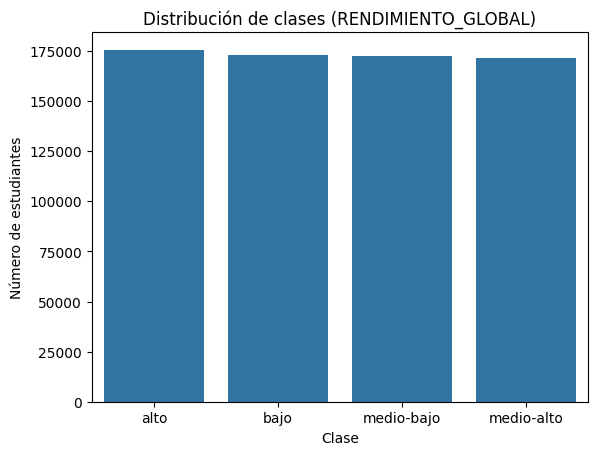

In [3]:
# Distribución de la variable objetivo
print("\nDistribución de RENDIMIENTO_GLOBAL:")
print(df['RENDIMIENTO_GLOBAL'].value_counts())

# Gráfico de barras: clases
sns.countplot(data=df, x='RENDIMIENTO_GLOBAL', order=df['RENDIMIENTO_GLOBAL'].value_counts().index)
plt.title("Distribución de clases (RENDIMIENTO_GLOBAL)")
plt.ylabel("Número de estudiantes")
plt.xlabel("Clase")
plt.show()

# Conteo por municipio (si está disponible)
if 'ESTU_CODIGO_MCPIO_PRESENTACION' in df.columns:
    print("\nTop 10 municipios con más estudiantes:")
    print(df['ESTU_CODIGO_MCPIO_PRESENTACION'].value_counts().head(10))

In [4]:
# PREPROCESAMIENTO
# Filtrar columnas relevantes
df = df[['FAMI_EDUCACIONMADRE', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'RENDIMIENTO_GLOBAL']]

# Limpiar nulos
df.FAMI_EDUCACIONMADRE.values[df.FAMI_EDUCACIONMADRE.isna()] = 'no info'
df.ESTU_VALORMATRICULAUNIVERSIDAD.values[df.ESTU_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'

# Convertir rangos de matrícula a valores continuos
cmap = {
    'Entre 1 millón y menos de 2.5 millones': 1.75,
    'Entre 2.5 millones y menos de 4 millones': 3.25,
    'Menos de 500 mil': 0.250,
    'Entre 500 mil y menos de 1 millón': 0.75,
    'Entre 4 millones y menos de 5.5 millones': 4.75,
    'Más de 7 millones': 7.75,
    'Entre 5.5 millones y menos de 7 millones': 6.25,
    'No pagó matrícula': 0,
    'no info': -1
}
df['ESTU_VALORMATRICULAUNIVERSIDAD'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].map(cmap)

# One-hot encoding a FAMI_EDUCACIONMADRE
x = df.FAMI_EDUCACIONMADRE.values
FAMI_EDUCACIONMADRE_vals = sorted(np.unique(x))
FAMI_EDUCACIONMADRE_onehot_vals = {
    val: np.eye(len(FAMI_EDUCACIONMADRE_vals))[i] for i, val in enumerate(FAMI_EDUCACIONMADRE_vals)
}
FAMI_EDUCACIONMADRE_onehot_enc = np.r_[
    [FAMI_EDUCACIONMADRE_onehot_vals[i] for i in df.FAMI_EDUCACIONMADRE]
]
FAMI_EDUCACIONMADRE_df = pd.DataFrame(
    FAMI_EDUCACIONMADRE_onehot_enc,
    columns=[f"FAMI_EDUCACIONMADRE__{v}" for v in FAMI_EDUCACIONMADRE_onehot_vals]
)

# Concatenar y limpiar columna original
df = pd.concat([FAMI_EDUCACIONMADRE_df, df], axis=1).drop('FAMI_EDUCACIONMADRE', axis=1)

# Codificar variable objetivo
rmap = {'alto': 3, 'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2}
df['RENDIMIENTO_GLOBAL'] = [rmap[i] for i in df['RENDIMIENTO_GLOBAL']]

# Resultado final
print("Shape final del dataframe:", df.shape)
print(df.head())

Shape final del dataframe: (692500, 15)
   FAMI_EDUCACIONMADRE__Educación profesional completa  \
0                                                0.0     
1                                                0.0     
2                                                0.0     
3                                                0.0     
4                                                0.0     

   FAMI_EDUCACIONMADRE__Educación profesional incompleta  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   FAMI_EDUCACIONMADRE__Ninguno  FAMI_EDUCACIONMADRE__No Aplica  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2                           0.0                  